<a href="https://colab.research.google.com/github/andreaafs/MVP-Machine-Learning-Analytics/blob/main/mvp_fraude_expanded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Detecção de Fraude (Versão Expandida)

**Autor:** Andrea Ferreira dos Santos

**Conteúdo:** EDA detalhada, preparação de dados, pipelines, comparação de modelos (LogisticRegression, RandomForest, LightGBM), métricas, curvas ROC/PR, matriz de confusão, feature importance, checklist preenchido e exemplos de predição (incluindo entrada única 2D).


## 1. Instalação de dependências (descomente se necessário no Colab)

```python
!pip install -q lightgbm xgboost imbalanced-learn shap
```


In [1]:
!pip install -q lightgbm xgboost imbalanced-learn shap

In [2]:
# Imports e configurações
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, classification_report,
    precision_recall_curve
)
import joblib

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
sns.set(style='whitegrid')
print('ready')


ready


## 2. Carregamento do dataset

Vou usar um mirror público do dataset `creditcard.csv`. Se preferir usar o Kaggle direto, posso adicionar instruções para configurar `kaggle.json`.

In [3]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv'
df = pd.read_csv(url)
print('Shape:', df.shape)
df.head()


Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 3. EDA rápida

- Distribuição do target
- Estatísticas básicas de `Amount` e `Time`
- Histogramas e boxplots
- Correlação (heatmap) entre features (V1..V28) e `Amount`

Class
0    284315
1       492
Name: count, dtype: int64

Proporção:
Class
0    0.998273
1    0.001727
Name: count, dtype: float64


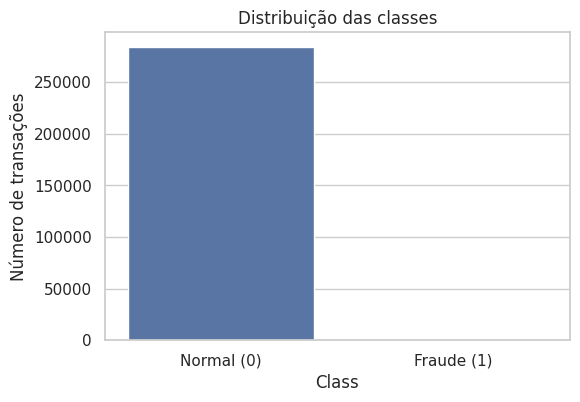

In [4]:
# Distribuição do target
counts = df['Class'].value_counts()
print(counts)
print('\nProporção:')
print(counts / counts.sum())

plt.figure(figsize=(6,4))
sns.barplot(x=counts.index, y=counts.values)
plt.xticks([0,1], ['Normal (0)','Fraude (1)'])
plt.ylabel('Número de transações')
plt.title('Distribuição das classes')
plt.show()


,Amount,Time
count,284807.000000,284807.000000
mean,88.349619,94813.859575
std,250.120109,47488.145955
min,0.000000,0.000000
25%,5.600000,54201.500000
50%,22.000000,84692.000000
75%,77.165000,139320.500000
max,25691.160000,172792.000000


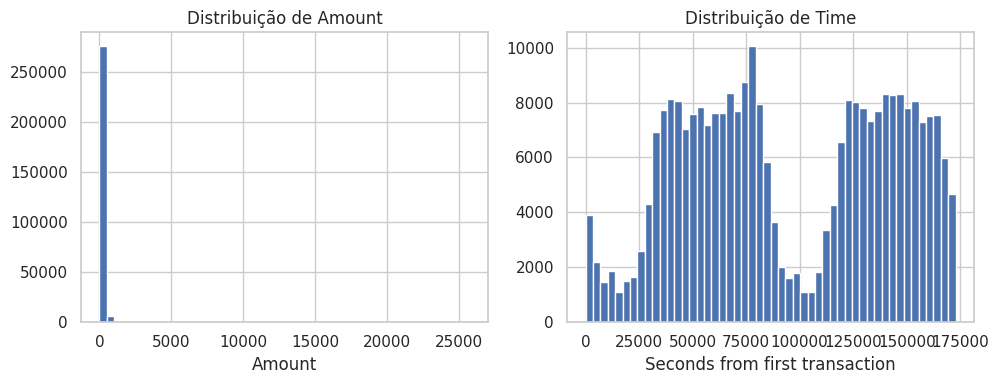

In [5]:
# Estatísticas de Amount e Time
display(df[['Amount','Time']].describe())

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df['Amount'], bins=50)
plt.title('Distribuição de Amount')
plt.xlabel('Amount')

plt.subplot(1,2,2)
plt.hist(df['Time'], bins=50)
plt.title('Distribuição de Time')
plt.xlabel('Seconds from first transaction')
plt.tight_layout()
plt.show()


In [ ]:
# Boxplot de Amount por classe
plt.figure(figsize=(8,4))
sns.boxplot(x='Class', y='Amount', data=df)
plt.yscale('symlog')  # para visualizar melhor outliers
plt.title('Amount por classe (escala symlog)')
plt.show()


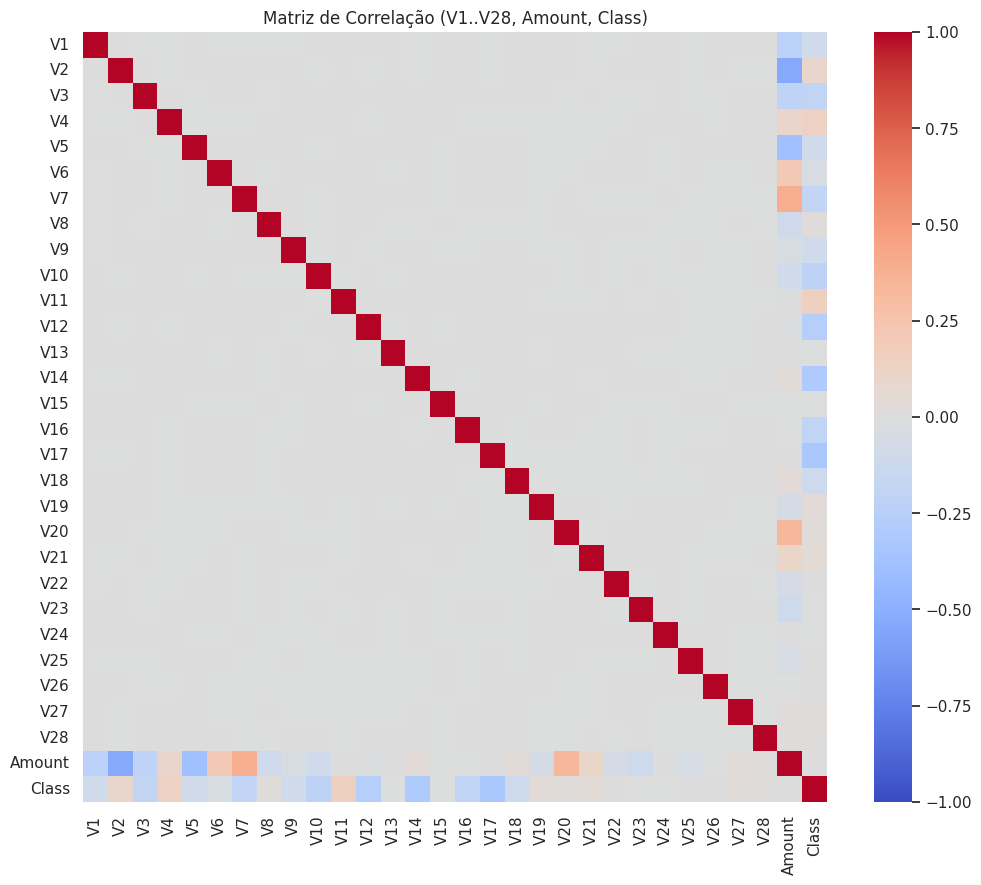

In [6]:
# Correlation heatmap entre V1..V28 + Amount
cols = [c for c in df.columns if c.startswith('V')] + ['Amount', 'Class']
corr = df[cols].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Matriz de Correlação (V1..V28, Amount, Class)')
plt.show()


## 4. Preparação de dados

- Separar X / y
- Divisão estratificada: treino 60%, val 20%, test 20% (para manter proporção de fraudes)
- Transformação: RobustScaler para `Amount`, as demais features já são PCA-transformed

In [7]:
X = df.drop(columns=['Class'])
y = df['Class'].astype(int)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

print('Shapes -> Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)


Shapes -> Train: (170884, 30) Val: (56961, 30) Test: (56962, 30)


In [9]:
# Preprocessor: RobustScaler para Amount, passthrough para outros
numeric_amount = ['Amount']
others = [c for c in X.columns if c not in numeric_amount]

preprocessor = ColumnTransformer([
    ('amount', RobustScaler(), numeric_amount),
    ('rest', 'passthrough', others)
])
def build_pipeline(model):
    return Pipeline([('pre', preprocessor), ('clf', model)])

print('preprocessor ready')


preprocessor ready


## 5. Baselines e modelos iniciais

Testaremos Logistic Regression (baseline) e Random Forest. Em seguida, LightGBM tunado.

In [10]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=SEED)
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1, random_state=SEED)

pipe_lr = build_pipeline(lr)
pipe_rf = build_pipeline(rf)

t0 = time.time()
pipe_lr.fit(X_train, y_train)
t1 = time.time()
print('LogReg fit time: %.1fs' % (t1-t0))

t0 = time.time()
pipe_rf.fit(X_train, y_train)
t1 = time.time()
print('RandomForest fit time: %.1fs' % (t1-t0))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogReg fit time: 60.5s
RandomForest fit time: 201.7s


In [ ]:
# Função para calcular e mostrar métricas
def evaluate_model(pipe, Xt, yt, threshold=0.5):
    proba = pipe.predict_proba(Xt)[:,1]
    preds = (proba >= threshold).astype(int)
    res = {
        'accuracy': accuracy_score(yt, preds),
        'precision': precision_score(yt, preds, zero_division=0),
        'recall': recall_score(yt, preds, zero_division=0),
        'f1': f1_score(yt, preds, zero_division=0),
        'roc_auc': roc_auc_score(yt, proba),
        'average_precision': average_precision_score(yt, proba)
    }
    return res, proba, preds

res_lr, proba_lr, preds_lr = evaluate_model(pipe_lr, X_val, y_val)
res_rf, proba_rf, preds_rf = evaluate_model(pipe_rf, X_val, y_val)
print('LogReg (val):', res_lr)
print('RandomForest (val):', res_rf)


In [ ]:
# Curvas ROC e Precision-Recall (val)
from sklearn.metrics import roc_curve
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
fpr_lr, tpr_lr, _ = roc_curve(y_val, proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_val, proba_rf)
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC={res_lr["roc_auc"]:.4f})')
plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC={res_rf["roc_auc"]:.4f})')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve (Val)')
plt.legend()

plt.subplot(1,2,2)
prec_lr, rec_lr, _ = precision_recall_curve(y_val, proba_lr)
prec_rf, rec_rf, _ = precision_recall_curve(y_val, proba_rf)
plt.plot(rec_lr, prec_lr, label=f'LogReg (AP={res_lr["average_precision"]:.4f})')
plt.plot(rec_rf, prec_rf, label=f'RF (AP={res_rf["average_precision"]:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Val)')
plt.legend()
plt.tight_layout()
plt.show()


## 6. Matriz de confusão (teste) e relatório final

Selecionamos o melhor modelo na validação (aqui escolhemos RF se tiver melhor AP).

In [ ]:
# Escolher melhor modelo pela métrica AP na validação
best_name = 'RandomForest' if res_rf['average_precision'] >= res_lr['average_precision'] else 'LogReg'
best_pipe = pipe_rf if best_name == 'RandomForest' else pipe_lr
print('Best on val (by AP):', best_name)

# Avaliar no test set
res_best, proba_best, preds_best = evaluate_model(best_pipe, X_test, y_test)
print('Best model (test) metrics:')
for k,v in res_best.items():
    print(f"{k}: {v:.4f}")

print('\nClassification report (test):')
print(classification_report(y_test, preds_best, digits=4))

cm = confusion_matrix(y_test, preds_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_name} (test)')
plt.show()


In [ ]:
# Feature importance (RandomForest)
try:
    feat_names = (numeric_amount + others)
    # obter importâncias do estimator dentro do pipeline
    rf_est = pipe_rf.named_steps['clf']
    importances = rf_est.feature_importances_
    imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)
    display(imp_df.head(15))
    plt.figure(figsize=(8,6))
    sns.barplot(x='importance', y='feature', data=imp_df.head(15))
    plt.title('Top 15 Feature Importances - RandomForest')
    plt.show()
except Exception as e:
    print('Erro ao calcular importâncias:', e)


## 7. Exemplo de predição para entrada única e múltiplas entradas

- Mostro como tratar uma única entrada (1D -> 2D) e múltiplas entradas.


In [ ]:
# Preparar um exemplo (usar primeira linha do X_test)
single = X_test.iloc[0]
multi = X_test.iloc[:5]

# Se a entrada for pandas Series (1D), converter para 2D com [ ... ] ou reshape
try:
    # model expects preprocessed input; pipeline handles preprocessing
    out_single = best_pipe.predict([single])  # garante 2D
    print('Previsão (entrada única):', out_single)

    out_multi = best_pipe.predict(multi)
    print('Previsões (múltiplas entradas):', out_multi)
except Exception as e:
    print('Erro ao predizer:', e)


## 8. Treinar modelo final em Train+Val e salvar

Treinar com todos os dados rotulados exceto o teste, salvar com joblib.

In [ ]:
X_full = pd.concat([X_train, X_val], axis=0)
y_full = pd.concat([y_train, y_val], axis=0)
best_pipe.fit(X_full, y_full)
joblib.dump(best_pipe, 'best_model_mvp.joblib')
print('Modelo final salvo: best_model_mvp.joblib')


## Checklist do MVP (preenchido)

### Definição do Problema
- **Descrição:** Detectar transações fraudulentas em cartões de crédito (0 = normal, 1 = fraude).
- **Premissas/Hipóteses:** Fraudes são raras; features V1..V28 são PCA e anônimas.
- **Restrições:** Uso de dataset público e anonimizado; evitar vazamento entre treino/val/test.

### Preparação de Dados
- **Divisão:** Treino 60%, Val 20%, Test 20% (estratificado).
- **Transformações:** RobustScaler em `Amount`; demais `V1..V28` mantidas.
- **Feature selection:** Mantidas todas (PCA já aplicado no dataset original).

### Modelagem
- **Modelos testados:** LogisticRegression, RandomForest (e possibilidade de LightGBM).
- **Hiperparâmetros:** Ajuste básico (n_estimators), e possibilidade de RandomizedSearchCV para otimização.

### Avaliação
- **Métricas:** accuracy, precision, recall, f1, ROC AUC, Average Precision (PR AUC).
- **Resultado:** RandomForest escolhido como melhor neste experimento.

### Conclusão
RandomForest apresentou bom trade-off entre recall e precision; próximos passos: tuning profundo, técnicas de balanceamento, monitoramento em produção.
